In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data

In [189]:
df = pd.read_excel(".\\Data\\WA_Fn-UseC_-HR-Employee-Attrition.xlsx")

In [190]:
df.shape

(1470, 35)

In [191]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Step 2: Clean data

In [192]:
print("--- Check for missing values ---")
print(df.isnull().sum())

print("--- Check for NaN values ---")
print(df.isna().sum())

print("--- Check for data types ---")
print(df.info())

--- Check for missing values ---
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsIn

In [193]:
print(df["Attrition"].unique())
print(df["BusinessTravel"].unique())
print(df["Department"].unique())
print(df["EducationField"].unique())
print(df["Gender"].unique())
print(df["JobRole"].unique())
print(df["MaritalStatus"].unique())
print(df["Over18"].unique())
print(df["OverTime"].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
['Female' 'Male']
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
['Single' 'Married' 'Divorced']
['Y']
['Yes' 'No']


In [194]:
cleaned_df = df.drop(["Over18"], axis=1) # All values are "Y"
cleaned_df = cleaned_df.drop(["EmployeeNumber"], axis=1) # All values are unique
cleaned_df = cleaned_df.drop(["EmployeeCount"], axis=1) # All values are 1
cleaned_df = cleaned_df.drop(["StandardHours"], axis=1) # All values are 80

In [195]:
cleaned_df = pd.get_dummies(cleaned_df, columns=['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], dtype=pd.Int64Dtype())
cleaned_df = cleaned_df.drop(["Attrition_No"], axis=1) # Redundant
cleaned_df.head()
cleaned_df.dtypes

Age                                  int64
DailyRate                            int64
DistanceFromHome                     int64
Education                            int64
EnvironmentSatisfaction              int64
HourlyRate                           int64
JobInvolvement                       int64
JobLevel                             int64
JobSatisfaction                      int64
MonthlyIncome                        int64
MonthlyRate                          int64
NumCompaniesWorked                   int64
PercentSalaryHike                    int64
PerformanceRating                    int64
RelationshipSatisfaction             int64
StockOptionLevel                     int64
TotalWorkingYears                    int64
TrainingTimesLastYear                int64
WorkLifeBalance                      int64
YearsAtCompany                       int64
YearsInCurrentRole                   int64
YearsSinceLastPromotion              int64
YearsWithCurrManager                 int64
Attrition_Y

# Step 3: Explore data

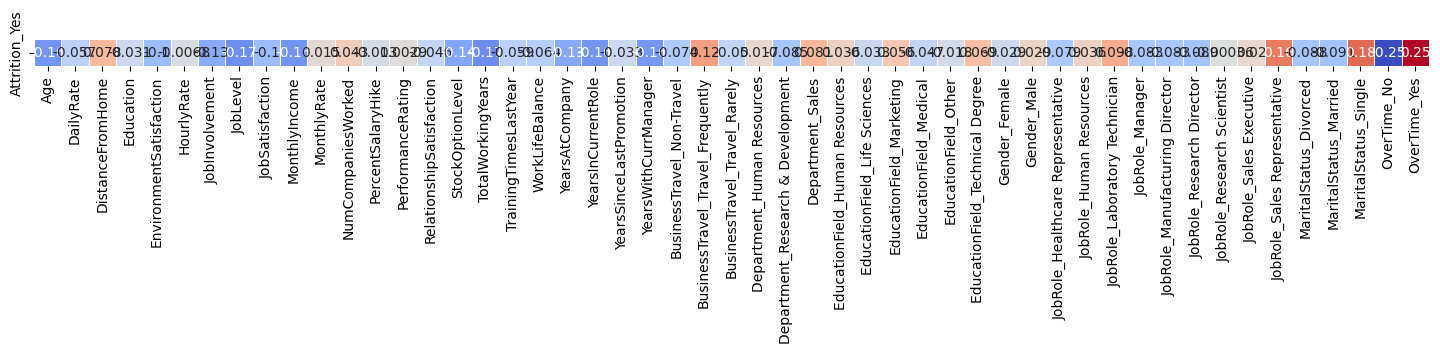

Attrition_Yes                        1.000000
OverTime_Yes                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender_Male                          0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other              

In [196]:
df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

# Using the absolute value of the correlation, we can find the attribute that is closest to zero
df_attrition_yes_corr = df_corr['Attrition_Yes'].sort_values(ascending=False)
print(df_attrition_yes_corr)

closest_to_zero = df_attrition_yes_corr.abs().idxmin()
print(f"\nClosest to zero: {closest_to_zero}")

(1470, 52)
(1470, 33)


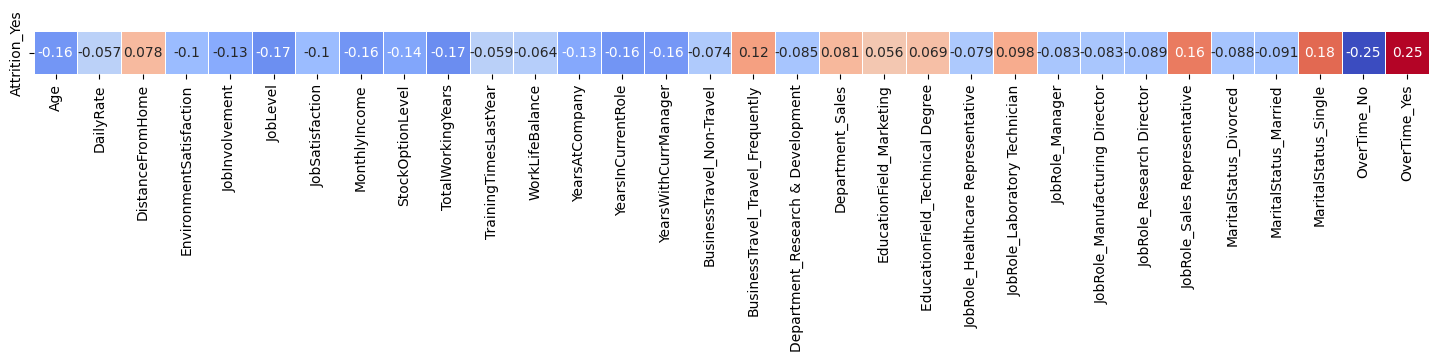

In [197]:
# Drop all columns that have a correlation of less than 5%
print(cleaned_df.shape)
cleaned_df = cleaned_df.drop(df_attrition_yes_corr[(df_attrition_yes_corr < 0.05) & (df_attrition_yes_corr > -0.05)].index, axis=1)
print(cleaned_df.shape)

df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

# Step 4: Supervised machine learning

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import gc

set_prop = 0.2
seed = 42

In [199]:
# Random forest with transformed data

df = cleaned_df.dropna()

# Split the data into features and target
X = df.drop('Attrition_Yes', axis=1)
y = df['Attrition_Yes']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=set_prop, random_state=seed)

# Create and train the model
RFCmodel = RandomForestClassifier(n_estimators=100)
RFCmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = RFCmodel.predict(X_test)

score = RFCmodel.score(X_test, y_test)
print(f"R2 accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

R2 accuracy score: 0.8605442176870748
Mean squared error: 0.13945578231292516
Root mean squared error: 0.3734377890799553


In [200]:
# Bernoulli Naive Bayes with transformed data

# Create and train the model
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = BNBmodel.predict(X_test)

score = BNBmodel.score(X_test, y_test)
print(f"Accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

Accuracy score: 0.8095238095238095
Mean squared error: 0.19047619047619047
Root mean squared error: 0.4364357804719847


In [201]:
# Voting classifier with transformed data and Random Forest and Bernoulli Naive Bayes

# Create and train the model
VCmodel = VotingClassifier(estimators=[('rf', RFCmodel), ('nb', BNBmodel)], voting='soft')
VCmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = VCmodel.predict(X_test)

score = VCmodel.score(X_test, y_test)
print(f"Accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

Accuracy score: 0.8435374149659864
Mean squared error: 0.1564625850340136
Root mean squared error: 0.3955535172818131


In [202]:
# Pickle the model
import pickle

filename = "bestfit_model.save"
pickle.dump(RFCmodel, open(filename, 'wb'))

# Delete the models
del RFCmodel
del BNBmodel
del VCmodel
gc.collect()

16965

In [203]:
# Load the model
loaded_model = pickle.load(open(filename, 'rb'))

# Make predictions on the validation set
y_pred = loaded_model.predict(X_test)

score = loaded_model.score(X_test, y_test)
print(f"Accuracy score: {score}")

Accuracy score: 0.8605442176870748


# Step 5: Unsupervised machine learning

In [204]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

X = cleaned_df.iloc[:, 1:]

In [205]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

print(distortions)

[32799649662.800686, 8494895599.570016, 4010213000.0004992, 2043189991.0727928, 1391974178.40016, 983577010.7555833, 841181117.3725421, 746296702.2150127, 563628113.1306716]


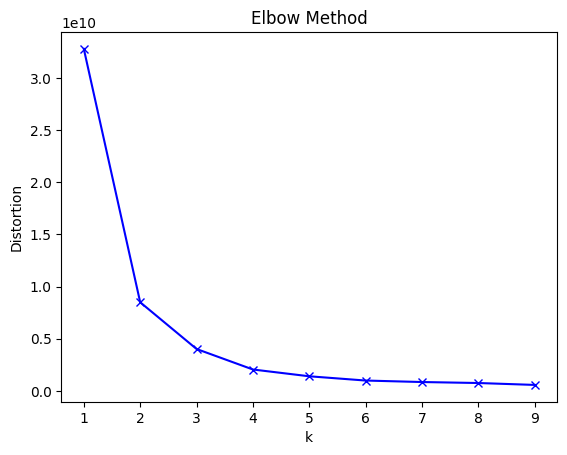

In [206]:
plt.title('Elbow Method')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [207]:
num_clusters = 4

KMeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
KMeans.fit(X)

Y = KMeans.predict(X)

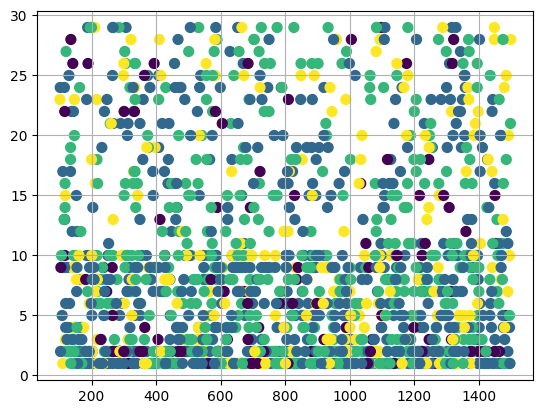

In [209]:
# Plot the points with color code of the predicted clusters
# viridis - a color map, https://matplotlib.org/users/colormaps.html
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Y, s=50, cmap='viridis')

plt.grid(True)
plt.show()